# Why Differentiable Spectral Modeling?

Last Update: January 19th (2025) Hajime Kawahara

[ExoJAX](https://github.com/HajimeKawahara/exojax) is a differentiable spectral model written in [JAX](https://jax.readthedocs.io/en/latest/). Here, we aim to provide a brief introduction to what can be achieved with differentiable models for users who may not be familiar with [Differentiable Programming](https://arxiv.org/abs/2403.14606) (DP).

Here, as the simplest example of a spectrum, we use an absorption spectrum consisting of a single hypothetical absorption line of a molecule X.
This absorption line follows a Voigt profile, characterized by a line profile centered at `nu0` , determined by the temperature-dependent core width `beta` and the temperature- and pressure-dependent wing width  `gamma` . The cross-section is given as follows:

Text(0, 0.5, 'cross section (cm$^2$)')

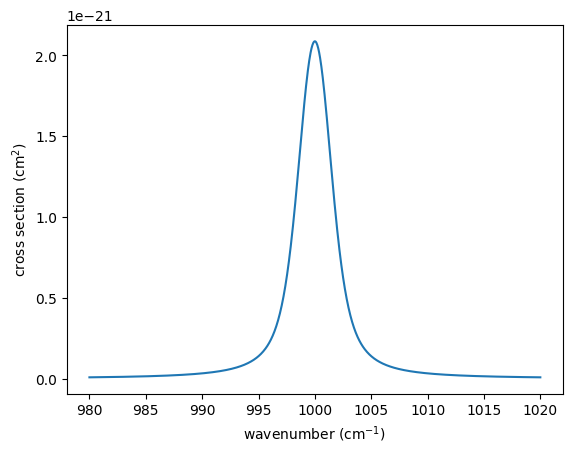

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from exojax.spec import voigt

logbeta = 1.0
gamma = 1.0
line_strength = 1.e-20 #cm2
nu0 = 1000.0
nu_grid = jnp.linspace(nu0-20,nu0+20,1000)


sigma = line_strength*voigt(nu_grid - nu0,logbeta,gamma)

plt.plot(nu_grid, sigma) 
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel("cross section (cm$^2$)")

When light with a flat spectrum $f_0$ passes through a region filled with molecule X at a number density $n$ over a path length $L$, the transmitted spectrum is given by 
$f_0 \exp(-\tau_\nu)$, where the optical depth $\tau_\nu = n L \sigma_\nu$. Using the column density $N = n L$, this can be expressed as 
$f_\nu = f_0 \exp{(-N \sigma_\nu )}$.

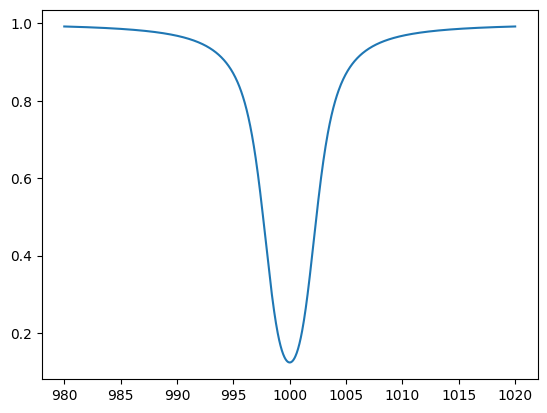

In [2]:
f0 = jnp.ones_like(nu_grid)
n = 1.e17
L = 1.e4
logN = n*L
f = f0*jnp.exp(-sigma*logN)

plt.plot(nu_grid, f)
plt.show()

Observed spectra always contain statistical errors. Here, we simplify by assuming wavenumber-independent Gaussian noise and add noise accordingly.

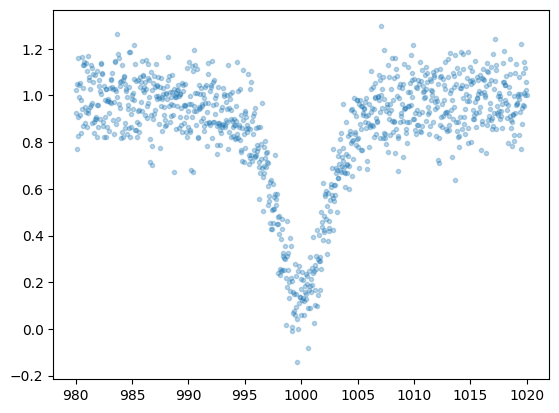

In [3]:
import numpy as np
sigma_noise = 0.1
np.random.seed(72)
fobs = f + np.random.normal(0.0,sigma_noise,len(f))
plt.plot(nu_grid, fobs, ".",alpha=0.3)
plt.show()

Now, what can a differentiable spectral model do with this observed spectrum? Let’s first assume that `gamma` is known and focus on estimating `N` and `beta`.

In [4]:
def fmodel(N,beta):
    gamma=1.0
    nu0 = 1000.0
    sigma = line_strength*voigt(nu_grid - nu0,beta,gamma)
    f = f0*jnp.exp(-sigma*N)
    return f

## gradient-based optimization

In a differentiable spectral model, gradient-based optimization is possible. Specifically, when $\chi^2$ is expressed as a function of `N` (normalized by 1e21) and `beta`, we can compute the gradients of $\chi^2$ with respect to `N` and `beta`. This allows us to determine the next step that minimizes $\chi^2$, following the same principle as descending along the slope of a hill toward the valley bottom. 

In [5]:
def chi2_fmodel(params):
    """differentiable chi2 function
    Args:
        params: logN (float), log surface density, logbeta (float), log beta

    Returns:
        float: chi2
    """
    logN, logbeta = params
    f = fmodel(10**logN,10**logbeta)
    return jnp.sum((f-fobs)**2/sigma_noise**2)

Here, let’s first check the distribution of $\chi^2$. However, this is only feasible because the parameter space is two-dimensional in this case. In general, such an approach would be challenging.

Text(0, 0.5, 'log beta')

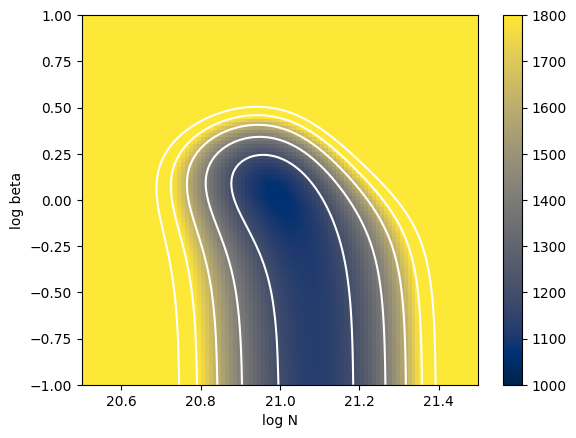

In [6]:
Narray = jnp.linspace(20.5, 21.5, 100)
betaarray = jnp.linspace(-1, 1, 100)


# unpacks parameters
def chi2_fmodel_unpackpar(logN, logbeta):
    return chi2_fmodel(jnp.array([logN, logbeta]))


from jax import vmap

vmapchi2 = vmap(vmap(chi2_fmodel_unpackpar, (0, None), 0), (None, 0), 0)
chi2arr = vmapchi2(Narray, betaarray)

a = plt.imshow(
    chi2arr[::-1, :],
    extent=(Narray[0], Narray[-1], betaarray[0], betaarray[-1]),
    aspect="auto",
    cmap="cividis",
    vmin=1000,
    vmax=1800,
)
cb = plt.colorbar(a)
levels = [1000, 1200, 1400, 1600, 1800, 2000]
plt.contour(Narray, betaarray, chi2arr, levels=levels, colors="white")
plt.xlabel("log N")
plt.ylabel("log beta")

The key point here is that the $\chi^2$ defined using a differentiable spectral model is itself differentiable with respect to the parameters.

In [7]:
from jax import grad
dchi2 = grad(chi2_fmodel)
logNinit = 20.75
logbetainit = 0.5
params_init = jnp.array([logNinit,logbetainit])
dchi2(params_init)

Array([-5261.481 ,  4553.8516], dtype=float32)

Let’s perform gradient-based optimization using the (differentiable) $\chi^2$ as the cost function. 
The simplest gradient optimization method, steepest gradient descent, starts from an initial value and updates the parameters in the negative gradient direction. 
The step size $\eta$ determines the magnitude of each update step.

${\bf p}_n = {\bf p}_{n-1} - \eta \left( \frac{ d {\bf \chi^2}}{d {\bf p}} \right)_{n-1}$

In [8]:
eta = 1.e-5
Nstep = 30 
params = jnp.copy(params_init)
trajectory = []
for i in range(Nstep):
    trajectory.append(params)
    params = params - eta*dchi2(params)

trajectory = jnp.array(trajectory)
    

Let’s plot the trajectory of parameter updates using the steepest gradient descent method. You can observe the parameters being updated toward the local minimum. It’s interesting to experiment with different values of $\eta$. If $\eta$ is too large, the updates overshoot and oscillate across the valley, while if it’s too small, the descent toward the minimum becomes very slow. However, with an appropriate step size, the optimization proceeds efficiently.

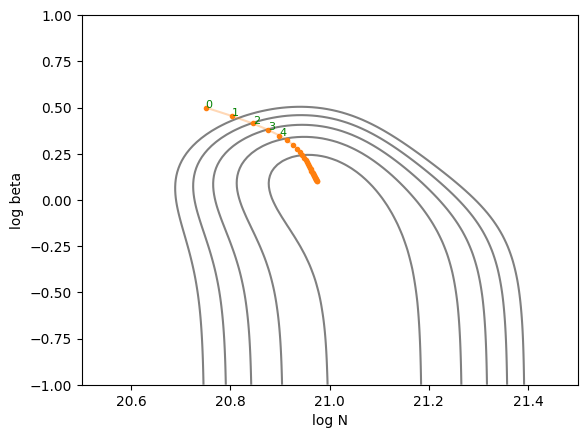

In [9]:
def plot_trajectory(trajectory):
    plt.contour(
    Narray,
    betaarray,
    chi2arr,
    levels=levels,
    colors="gray",
)
    plt.xlabel("log N")
    plt.ylabel("log beta")
    plt.plot(trajectory[:, 0], trajectory[:, 1], ".", color="C1")
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="C1", alpha=0.3)
    for i in range(5):
        plt.text(trajectory[i, 0], trajectory[i, 1], str(i), fontsize=8, color="green")

plot_trajectory(trajectory)

In JAX, [various gradient optimization techniques](https://optax.readthedocs.io/en/latest/api/optimizers.html) can be easily implemented using [Optax](https://optax.readthedocs.io/en/latest/index.html). 
Here, we’ll use one of the commonly used optimizers, ADAM, to find the parameters that minimize (or more precisely, locally minimize) $\chi^2$.

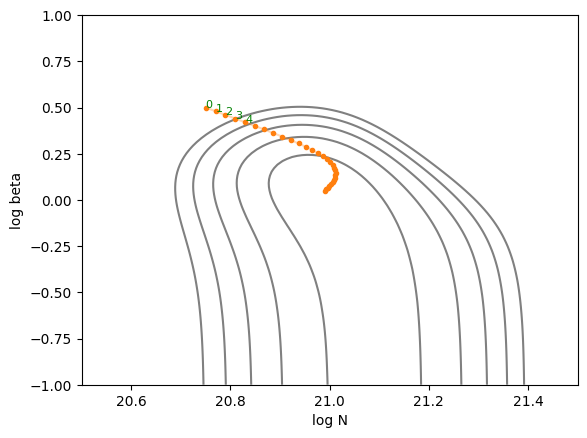

In [10]:
import optax

solver = optax.adam(learning_rate=0.02)
opt_state = solver.init(params_init)
Nstep = 30
params = jnp.copy(params_init)

trajectory_adam = []
for i in range(Nstep):
    trajectory_adam.append(params)
    grad = dchi2(params)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

plot_trajectory(jnp.array(trajectory_adam))    

Using the updated parameters to predict the spectrum results in the following:

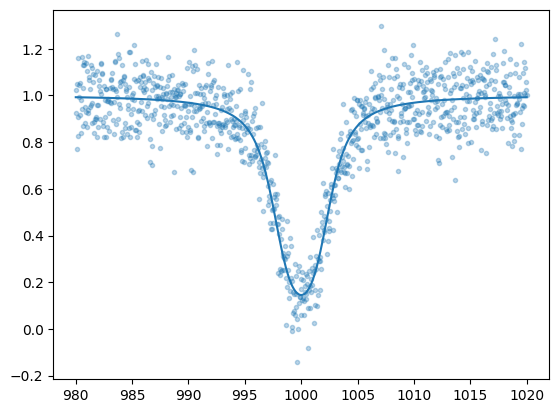

In [11]:

plt.plot(nu_grid, fobs, ".", alpha=0.3)
plt.plot(nu_grid, fmodel(10**params[0],10**params[1]), color="C0")
plt.show()

## MCMC sampling using HMC-NUTS

Formal Explanation of HMC-NUTS


Hamiltonian Monte Carlo (HMC) is a Markov Chain Monte Carlo (MCMC) technique designed to efficiently sample from complex posterior distributions, often encountered in Bayesian inference. Unlike simpler methods such as Metropolis-Hastings or Gibbs sampling, HMC leverages concepts from physics, specifically Hamiltonian dynamics, to guide the sampling process. By introducing an auxiliary momentum variable and simulating the system’s energy-conserving trajectories, HMC is able to make larger, more informed proposals in the parameter space, thereby reducing the autocorrelation in the samples and improving the overall efficiency. This can be particularly helpful in high-dimensional inference problems common in astronomy (e.g., inferring orbital parameters of multiple exoplanets), where naive random-walk behavior can lead to very slow convergence.

The No-U-Turn Sampler (NUTS) is an extension of HMC that addresses a practical challenge: choosing the trajectory length (i.e., how long the Hamiltonian system is simulated before making a new proposal). Picking this length by hand can be difficult and problem-dependent. NUTS automatically determines how far to run the Hamiltonian dynamics in each iteration by building a balanced tree of possible trajectories and stopping when it detects a “U-turn” in the parameter space, indicating that further exploration would start retracing its path. This adaptation helps ensure that you sample efficiently without requiring manual tuning of trajectory lengths. In practice, many modern Bayesian software packages (like Stan, PyMC, and Numpyro) implement NUTS by default, which makes it widely accessible for astronomers who need robust sampling methods for their complex models.


The formal explanation of HMC-NUTS above was generated by ChatGPT o1 (sorry)! In essence, HMC-NUTS is the de facto standard MCMC method in Bayesian statistics. To sample using HMC-NUTS, the model must be differentiable, and the models we’ve written so far are, of course, differentiable. To apply HMC-NUTS to models written in JAX, libraries such as NumPyro and BlackJAX can be used. Here, we’ll use NumPyro.

In [12]:
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from jax import random

In [23]:
def model(y):
    logN = numpyro.sample('logN', dist.Uniform(20.5, 21.5))
    logbeta = numpyro.sample('logbeta', dist.Uniform(-1, 1))
    sigmain = numpyro.sample('sigmain', dist.Exponential(10.0))
    N = 10**logN
    beta = 10**logbeta
    mu = fmodel(N,beta)
    numpyro.sample('y', dist.Normal(mu, sigmain), obs=y)

In [24]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y=fobs)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 367.22it/s, 3 steps of size 6.79e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      logN     20.99      0.01     20.99     20.97     21.01   1216.97      1.00
   logbeta      0.01      0.03      0.02     -0.03      0.06   1406.12      1.00
   sigmain      0.10      0.00      0.10      0.10      0.11   1592.41      1.00

Number of divergences: 0


In [25]:
import arviz
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive


In [26]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model, posterior_sample, return_sites=['y'])
predictions = pred(rng_key_, y=None)
median_mu1 = jnp.median(predictions['y'], axis=0)
hpdi_mu1 = hpdi(predictions['y'], 0.9)

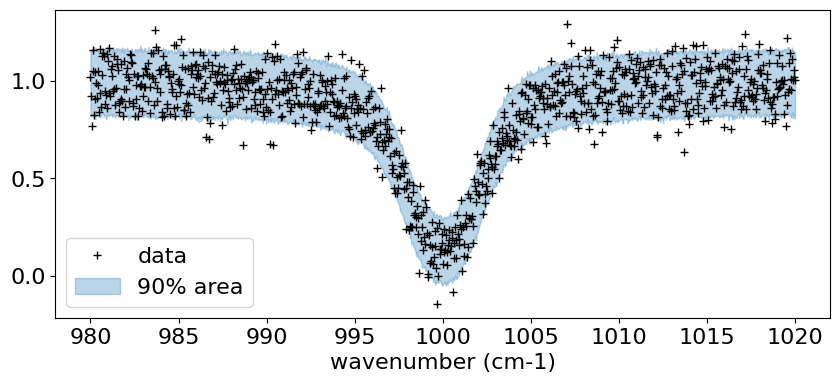

In [28]:
# PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
#ax.plot(nu_grid, median_mu1, color='C0')
ax.plot(nu_grid, fobs, '+', color='black', label='data')
ax.fill_between(nu_grid,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C0',
                label='90% area')

plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

array([[<Axes: ylabel='logN'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='logbeta'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='logN', ylabel='sigmain'>,
        <Axes: xlabel='logbeta'>, <Axes: xlabel='sigmain'>]], dtype=object)

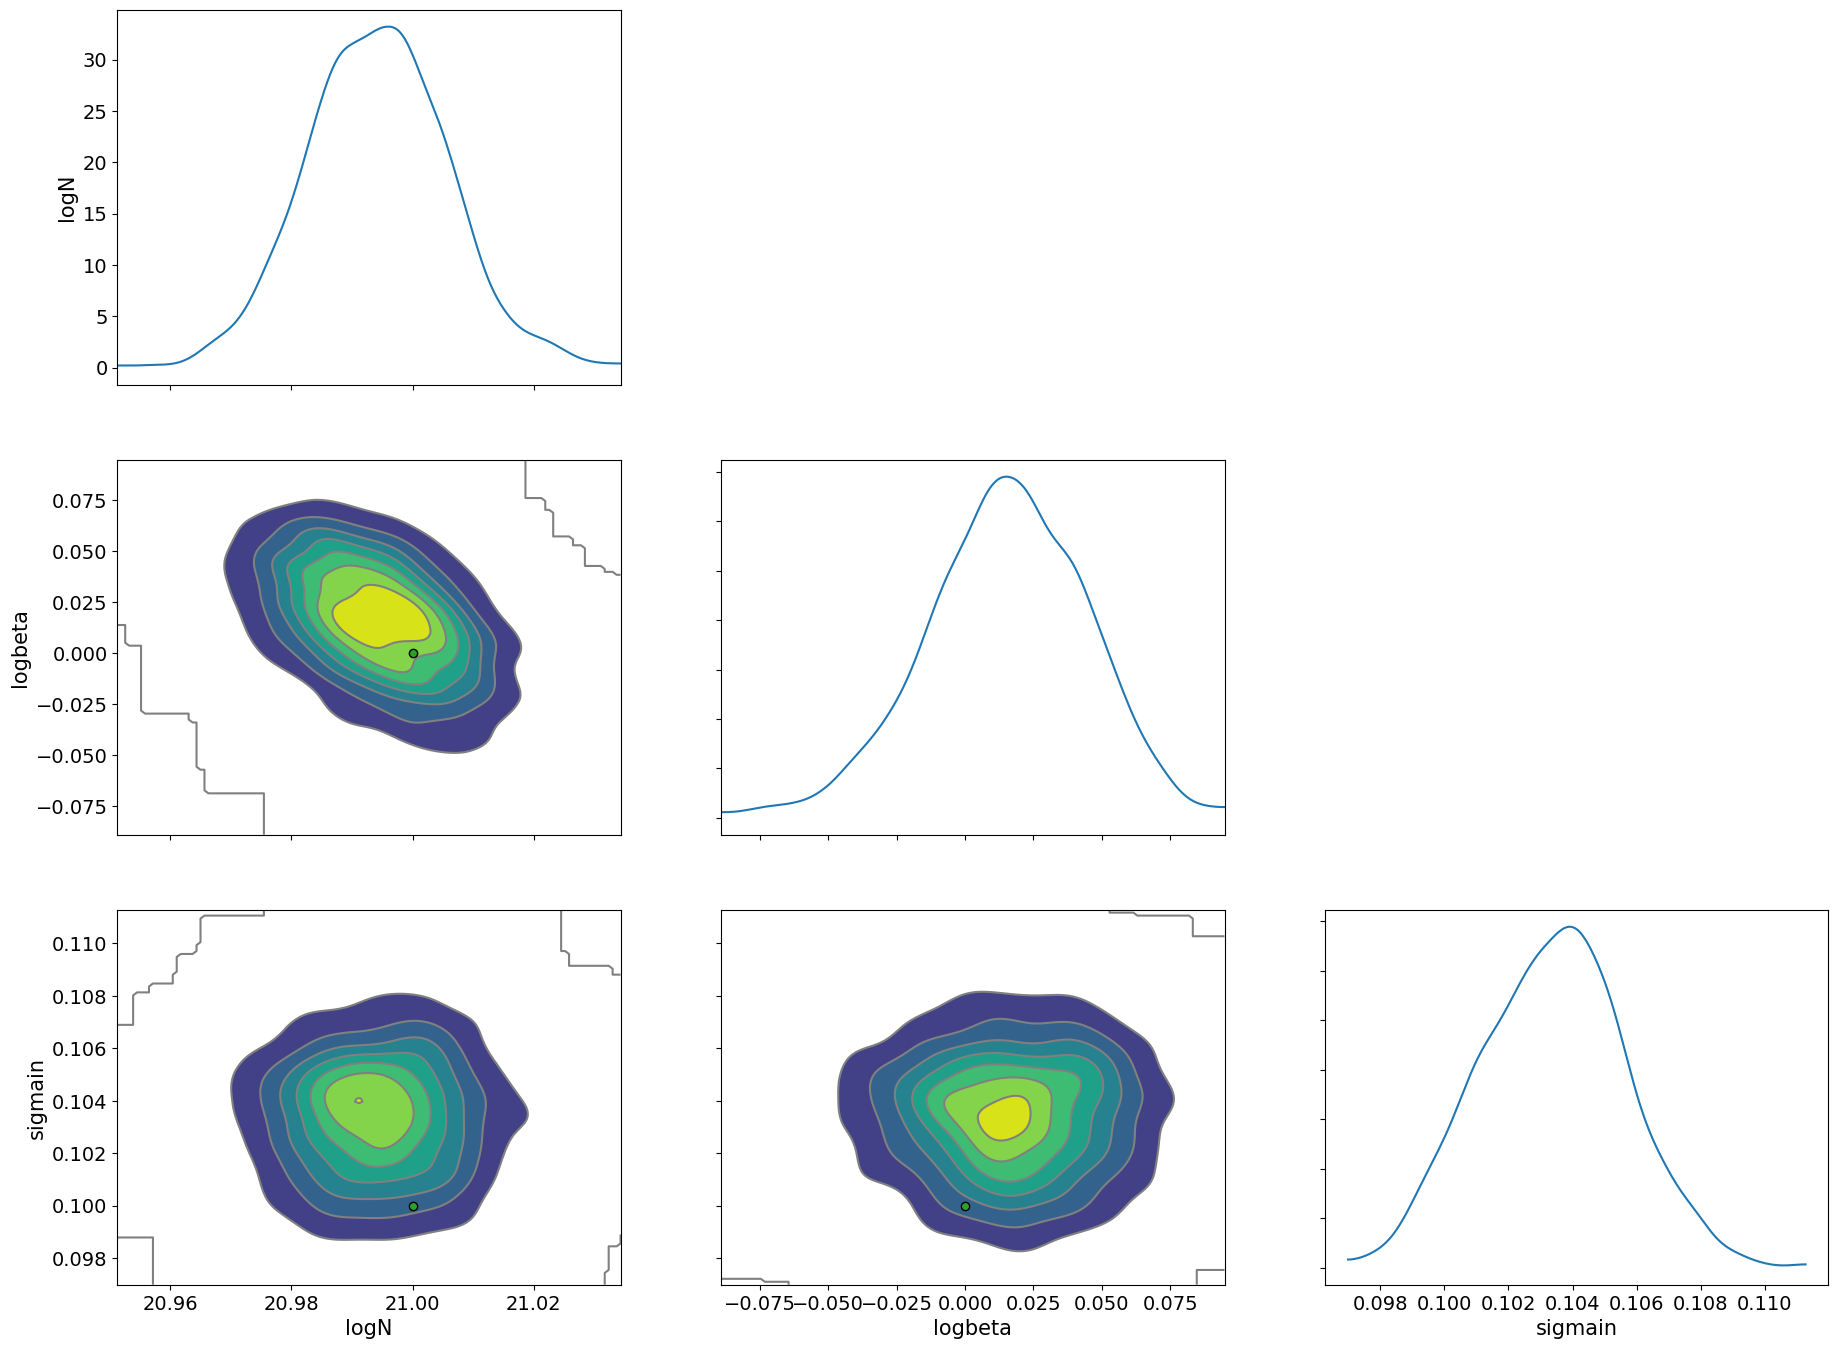

In [ ]:
pararr = ["logN", "logbeta", "sigmain"]
arviz.plot_pair(
    arviz.from_numpyro(mcmc),
    kind="kde",
    divergences=False,
    marginals=True,
    reference_values={"logN": 21.0, "logbeta": 0.0, "sigmain": 0.1},
)